In [2]:
import pickle
import os, sys
import numpy as np
import pandas as pd

In [3]:
parameters = {
    'path': os.path.dirname(sys.path[0]),
    'path_in': os.path.join(os.path.dirname(sys.path[0]), '01_data'),
    'path_out': os.path.join(os.path.dirname(sys.path[0]), '02_output')
}

{'path': '/Users/davinanaya/Desktop/ELE-Machine-Learning', 'path_in': '/Users/davinanaya/Desktop/ELE-Machine-Learning/01_data', 'path_out': '/Users/davinanaya/Desktop/ELE-Machine-Learning/02_output'}


In [4]:
# Función para desempaquetar los archivos
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Lista para almacenar los datos
batches = []

# Update the data_dir path to the correct directory path
data_dir = os.path.join(parameters['path_in'], 'cifar-10-batches-py')

# Cargar cada archivo en la carpeta
for filename in os.listdir(data_dir):
    if filename.startswith('data_batch'):
        file_path = os.path.join(data_dir, filename)
        print(filename)
        data_dict = unpickle(file_path)
        batches.append(data_dict)

# Ahora 'data' es una lista con todas las imágenes del conjunto de datos
print(f'Número total de batches procesados: {len(batches)}')

data_batch_1
data_batch_2
data_batch_5
data_batch_4
data_batch_3
Número total de batches procesados: 5


In [50]:
# Extraer la data y las etiquetas
data = np.vstack([batch[b'data'] for batch in batches])
labels = np.hstack([batch[b'labels'] for batch in batches])

In [37]:
meta_data = unpickle(os.path.join(data_dir, 'batches.meta'))
label_meta = meta_data[b'label_names']
label_mapping = {i: label_meta[i].decode('utf-8') for i in range(len(label_meta))}

In [8]:
# Transformando los datos a su forma original (32x32x3)
images = data.reshape(len(data), 3, 32, 32).transpose(0, 2, 3, 1)
images[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

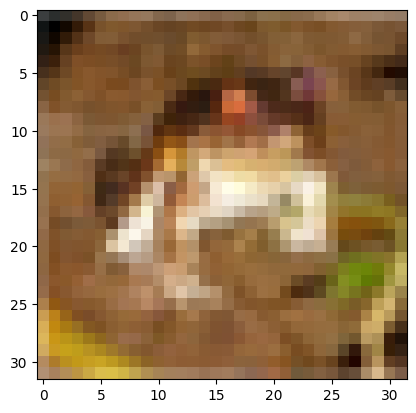

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Mostrar una imagen
plt.imshow(images[0])

In [39]:
import numpy as np
import pandas as pd

# Convertir la lista en un array de numpy
data_array = np.array(data)

# Convertir el array en un DataFrame de pandas
df = pd.DataFrame(data_array)
df["labels"] = labels
df["label_name"] = df["labels"].map(label_mapping)
df

,0,1,2,3,4,5,6,7,8,9,...,3064,3065,3066,3067,3068,3069,3070,3071,labels,label_name
0,59,43,50,68,98,119,139,145,149,149,...,65,59,46,57,104,140,84,72,6,frog
1,154,126,105,102,125,155,172,180,142,111,...,67,101,122,133,136,139,142,144,9,truck
2,255,253,253,253,253,253,253,253,253,253,...,80,69,66,72,79,83,83,84,9,truck
3,28,37,38,42,44,40,40,24,32,43,...,59,42,44,48,38,28,37,46,4,deer
4,170,168,177,183,181,177,181,184,189,189,...,85,82,83,79,78,82,78,80,1,automobile
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,25,25,26,27,27,27,28,29,29,28,...,176,175,175,175,175,175,178,155,2,bird
49996,65,66,69,73,75,72,68,65,63,62,...,48,48,48,44,40,39,38,36,5,dog
49997,175,200,207,206,191,174,157,151,146,97,...,202,164,138,98,118,124,49,32,3,cat
49998,28,59,67,71,30,59,71,49,45,58,...,35,49,58,54,48,36,44,41,7,horse


In [53]:
df.value_counts("label_name")

label_name
airplane      5000
automobile    5000
bird          5000
cat           5000
deer          5000
dog           5000
frog          5000
horse         5000
ship          5000
truck         5000
Name: count, dtype: int64